In [1]:
import jsonlines
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE
import numpy as np
from scipy.sparse import csr_matrix
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import sys
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import string
import re
warnings.filterwarnings("ignore")

In [2]:
def read_df (file_path):
    
    mensajes = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
            # Cada línea es un objeto JSON
                mensaje = json.loads(line.rstrip())
                mensajes.append(mensaje)
    except FileNotFoundError:
        print(f"El archivo no se encontró: {file_path}")

    return pd.DataFrame(mensajes)

#LECTURA DE LA DATA
data_path = 'data/'
input1= 'test.jsonl'
input2= 'train.jsonl'
file_path1 = data_path + input1
file_path2 = data_path + input2

mensajes_test= read_df(file_path1)
mensajes_train= read_df(file_path2)

In [3]:
mensajes_train.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [4]:
#LEER LAS COLUMNAS DEL DICIONARIO
#for mensaje in mensajes:
    #years = mensaje.get('years', 'Clave no encontrada')
    #game_score = mensaje.get('game_score', 'Clave no encontrada')
    #game_score_delta = mensaje.get('game_score_delta', 'Clave no encontrada')
    #players = mensaje.get('players', 'Clave no encontrada')
    #game_id = mensaje.get('game_id', 'Clave no encontrada')

    # Imprime los valores
    #print(f"Years: {years}")
    #print(f"Game Score: {game_score}")
    #print(f"Game Score Delta: {game_score_delta}")
    #print(f"Players: {players}")
    #print(f"Game ID: {game_id}")
    #print("------")

In [5]:
# CONVERTIR A DATAFRAME
df_test = pd.DataFrame(mensajes_test)
df_train = pd.DataFrame(mensajes_train)

print(df_train.columns)
print(df_test.columns)
#print(df_train.columns == df_test.columns)
#print(df_train.head(1))

Index(['messages', 'sender_labels', 'receiver_labels', 'speakers', 'receivers',
       'absolute_message_index', 'relative_message_index', 'seasons', 'years',
       'game_score', 'game_score_delta', 'players', 'game_id'],
      dtype='object')
Index(['messages', 'sender_labels', 'receiver_labels', 'speakers', 'receivers',
       'absolute_message_index', 'relative_message_index', 'seasons', 'years',
       'game_score', 'game_score_delta', 'players', 'game_id'],
      dtype='object')


In [6]:
#GUARDA UN DATAFRAME EN UN CSV
df_test_to_csv =  df_train.to_csv(data_path + 'train.csv', index=False)
df_train_to_csv = df_test.to_csv (data_path + 'test.csv', index=False)
#NUEVA COLUMNA PARA SABER LA LONGITUD DE LOS MENSAJES Y SABER COMO SE COMPORTA
df_test ["longitud_test"]= df_test ["messages"].apply(len)
df_train["longitud_train"]= df_train["messages"].apply(len)

In [7]:
#### ******** CONOCIENDO LOS DATOS VISUALMENTE ********

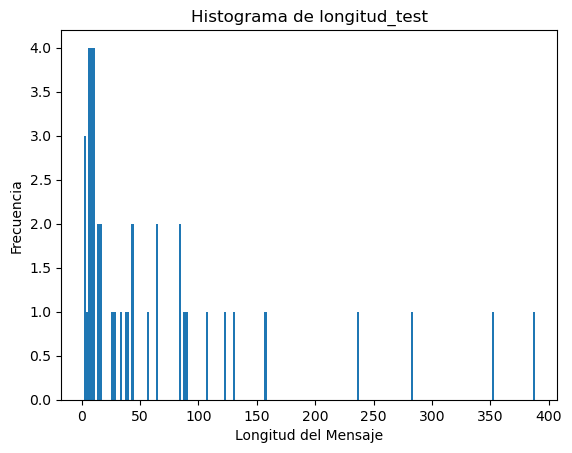

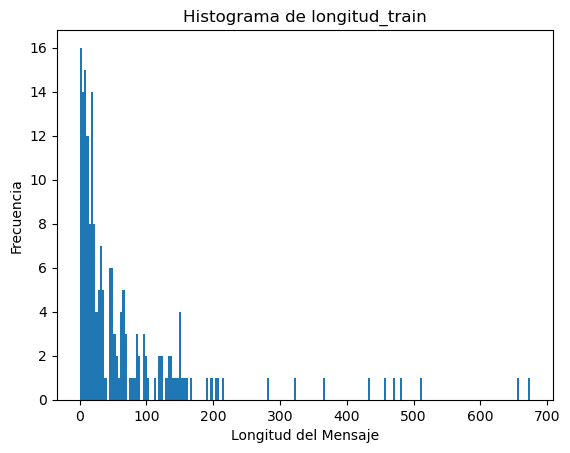

In [8]:
plt.figure()
#plt.figure(figsize=(10,6))
df_test["longitud_test"].plot.hist(bins=200)
plt.xlabel('Longitud del Mensaje')
plt.ylabel('Frecuencia')
plt.title('Histograma de longitud_test')
plt.show()

plt.figure()
#plt.figure(figsize=(10,6))
df_train["longitud_train"].plot.hist(bins=200)
plt.xlabel('Longitud del Mensaje')
plt.ylabel('Frecuencia')
plt.title('Histograma de longitud_train')
plt.show()
#DONDE MAS HAY MENSAJES CON RESPECTO A LA LONGITUD ES EN 0 Y 100 CON UNA FRECUENCIA ALTA DE 16
#FRECUENCIA DEL NUMERO DE MENSAJES QUE TIENE ESA LONGITUD

In [9]:
#SACANDO UNA DESCRIPCION DE LOS DATOS PARA SABER SU COMPORTAMIENTO
df_test["longitud_test"].describe()
print(df_test["longitud_test"].describe())
df_train["longitud_train"].describe()
print(df_train["longitud_train"].describe())
#COUNT numero de elementos que hay
#mean promedio
#df[df["longitud"]==388]["messages"].iloc[0]

count     42.000000
mean      65.261905
std       92.937445
min        2.000000
25%        8.000000
50%       28.000000
75%       84.000000
max      388.000000
Name: longitud_test, dtype: float64
count    189.000000
mean      69.481481
std      109.868422
min        0.000000
25%       11.000000
50%       29.000000
75%       81.000000
max      675.000000
Name: longitud_train, dtype: float64


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
        <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>,
        <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>]], dtype=object)

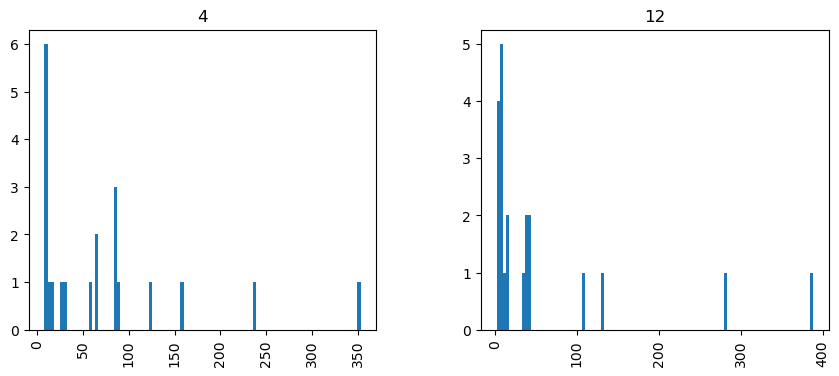

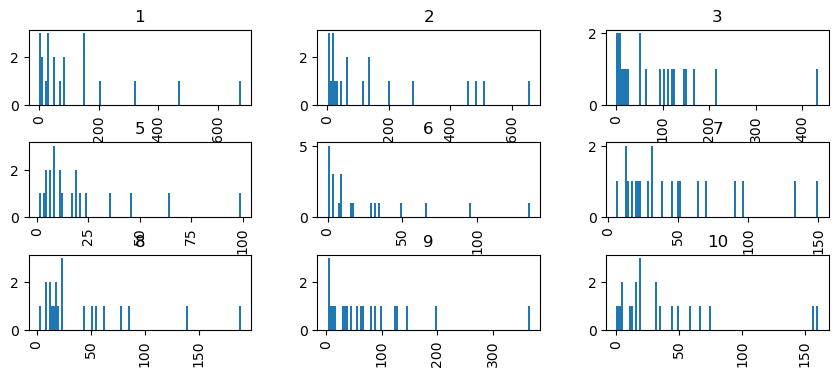

In [15]:
#SACANDO UN HISTOGRAMA CON RESPECTO A LOS GAME_ID
df_test.hist(column= 'longitud_test' , by='game_id', bins=100,figsize=(10,4))
df_train.hist(column='longitud_train', by='game_id', bins=100,figsize=(10,4))


In [ ]:
# Revisar la distribución de clases en el conjunto de entrenamiento
print("Distribución de clases en el conjunto de entrenamiento:")
print(df_train['sender_annotation'].value_counts())

#SE CONCLUYO QUE EL CONJUNTO DE DATOS DE ENTRENAMIENTO NO ESTA BALANCEADO
#LO CUAL AFECTARIA AL MODELO


In [ ]:
# Descargar las stop words
#nltk.download('stopwords')
#nltk.download('punkt')
# cargar stop words en español (cambia 'spanish' por el idioma que necesites)
#stop_words = set(stopwords.words('english'))
#len(stop_words)
#print(stop_words)

#def limpiar_texto(texto):
    # Verificar si el texto no es una cadena
    # if not isinstance(texto, str):
    #     # Si el texto es una lista, únelo en una cadena
    #     if isinstance(texto, list):
    #         texto = ' '.join(texto)
    #         #print('si es una lista, unalo a una cadena',texto)
    #     else:
    #         return ""  # Si no es ni lista ni cadena, devuelve una cadena vacía

    # texto = texto.lower()  # Convertir a minúsculas
    # #print('texto en minnuscula',texto)
    # texto = re.sub(r'\W+', ' ', texto)  # Eliminar puntuación
    # #print('texto sin puntuacion',texto)

    # #tokenizar es dividir el texto en palabras
    # palabras = word_tokenize(texto)
    # #print('texto tokenizado',palabras)
    # # Eliminar las stop words
    # palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    # #print('texto filtrado',palabras_filtradas)
    # texto_limpio = ' '.join(palabras_filtradas)
    # print('texto limpio',texto_limpio)
    # return texto_limpio


# Suponiendo que tu DataFrame se llama 'df' y la columna con los mensajes se llama 'mensaje'
#df_test['mensaje_limpio'] = df_test['messages'].apply(limpiar_texto)